Eye-Tracking Metrics for HADS:
    Test  Average Pupil Dilation  Left Blink Rate (blinks/min)  Right Blink Rate (blinks/min) Pupil Dilation Increase Left Blink Rate Increase Right Blink Rate Increase
Baseline                2.513676                     15.717681                      16.840372                       -                        -                         -
 Test 01                2.841711                     13.913168                      13.378046                    True                    False                     False
 Test 02                1.949553                      9.399478                      14.099217                   False                    False                     False
 Test 03                2.357059                     16.096452                      17.043303                   False                     True                      True


NameError: name 'plt' is not defined

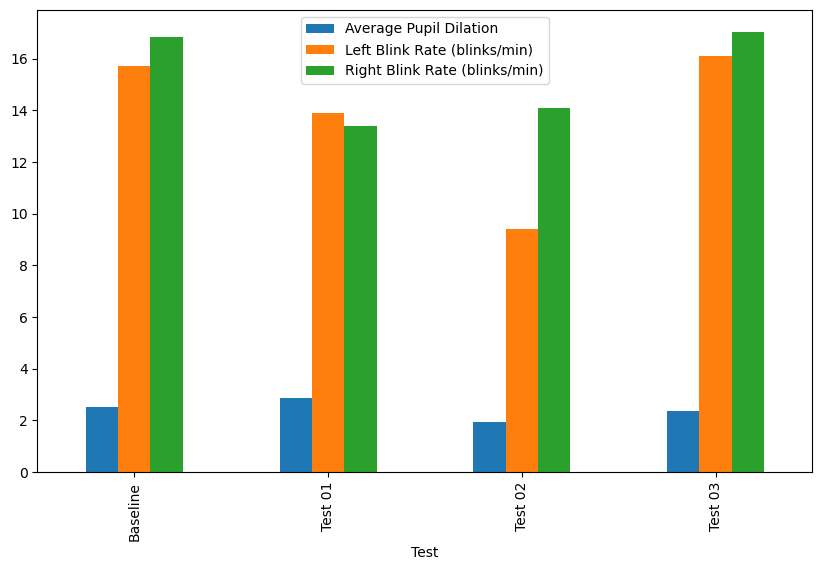

In [2]:
import pandas as pd

# Step 1: Load the data
baseline_eye_tracking = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed.csv')
eye_tracking_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_01.csv')
eye_tracking_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_02.csv')
eye_tracking_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_03.csv')

# Load psychometric test data for all three seasons
psychometric_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_01.csv')
psychometric_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_02.csv')
psychometric_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_03.csv')

# Step 2: Rename columns for consistency
columns_mapping = {
    'datetime': 'timestamp',
    'pupil': 'pupil_dilation',
    'leftEyeOpen': 'left_blink',
    'rightEyeOpen': 'right_blink'
}

baseline_eye_tracking.rename(columns=columns_mapping, inplace=True)
eye_tracking_01.rename(columns=columns_mapping, inplace=True)
eye_tracking_02.rename(columns=columns_mapping, inplace=True)
eye_tracking_03.rename(columns=columns_mapping, inplace=True)

# Step 3: Clean the data
def clean_eye_tracking_data(eye_tracking_data):
    # Convert 'timestamp' column to datetime format and ensure they are tz-naive
    eye_tracking_data['timestamp'] = pd.to_datetime(eye_tracking_data['timestamp'], errors='coerce').dt.tz_localize(None)
    # Remove rows with NaT values in timestamp
    eye_tracking_data = eye_tracking_data.dropna(subset=['timestamp'])
    return eye_tracking_data

baseline_eye_tracking = clean_eye_tracking_data(baseline_eye_tracking)
eye_tracking_01 = clean_eye_tracking_data(eye_tracking_01)
eye_tracking_02 = clean_eye_tracking_data(eye_tracking_02)
eye_tracking_03 = clean_eye_tracking_data(eye_tracking_03)

# Clean and prepare the psychometric data
psychometric_01.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_02.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_03.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']

# Convert 'datetime' columns to datetime format and ensure they are tz-naive
psychometric_01['Question Start Time'] = pd.to_datetime(psychometric_01['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Start Time'] = pd.to_datetime(psychometric_02['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Start Time'] = pd.to_datetime(psychometric_03['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_01['Question Answer Time'] = pd.to_datetime(psychometric_01['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Answer Time'] = pd.to_datetime(psychometric_02['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Answer Time'] = pd.to_datetime(psychometric_03['Question Answer Time'], errors='coerce').dt.tz_localize(None)

# Remove rows with NaT values in datetime columns
psychometric_01 = psychometric_01.dropna(subset=['Question Start Time'])
psychometric_02 = psychometric_02.dropna(subset=['Question Start Time'])
psychometric_03 = psychometric_03.dropna(subset=['Question Start Time'])

# Step 4: Filter for HADS questions
questions_hads_01 = psychometric_01[psychometric_01['Type'] == 'HADS'].copy()
questions_hads_02 = psychometric_02[psychometric_02['Type'] == 'HADS'].copy()
questions_hads_03 = psychometric_03[psychometric_03['Type'] == 'HADS'].copy()

def filter_eye_tracking_data(eye_tracking_data, questions):
    start_time = questions['Question Start Time'].min()
    end_time = questions['Question Answer Time'].max()
    return eye_tracking_data[(eye_tracking_data['timestamp'] >= start_time) & (eye_tracking_data['timestamp'] <= end_time)]

eye_tracking_hads_01 = filter_eye_tracking_data(eye_tracking_01, questions_hads_01)
eye_tracking_hads_02 = filter_eye_tracking_data(eye_tracking_02, questions_hads_02)
eye_tracking_hads_03 = filter_eye_tracking_data(eye_tracking_03, questions_hads_03)

# Step 5: Define function to calculate metrics
def calculate_eye_tracking_metrics(eye_tracking_data):
    # Calculate average pupil dilation
    average_pupil_dilation = eye_tracking_data['pupil_dilation'].mean()

    # Define a threshold to detect potential blinks (eye closed state)
    blink_detection_threshold = 1.0  # Threshold value to detect closed eyes

    # Detect potential blinks as transitions from above the threshold to below
    left_blink_count = ((eye_tracking_data['left_blink'] > blink_detection_threshold) & 
                        (eye_tracking_data['left_blink'].shift(-1) <= blink_detection_threshold)).sum()

    right_blink_count = ((eye_tracking_data['right_blink'] > blink_detection_threshold) & 
                         (eye_tracking_data['right_blink'].shift(-1) <= blink_detection_threshold)).sum()

    # Calculate total duration in minutes
    total_duration_minutes = (eye_tracking_data['timestamp'].max() - eye_tracking_data['timestamp'].min()).total_seconds() / 60

    # Calculate blink rate per minute
    left_blink_rate = left_blink_count / total_duration_minutes
    right_blink_rate = right_blink_count / total_duration_minutes

    return average_pupil_dilation, left_blink_rate, right_blink_rate

# Step 6: Calculate metrics for baseline and each test
baseline_metrics = calculate_eye_tracking_metrics(baseline_eye_tracking)
metrics_01 = calculate_eye_tracking_metrics(eye_tracking_hads_01)
metrics_02 = calculate_eye_tracking_metrics(eye_tracking_hads_02)
metrics_03 = calculate_eye_tracking_metrics(eye_tracking_hads_03)

# Step 7: Compare with baseline to detect significant increase
def detect_significant_increase(test_metrics, baseline_metrics):
    pupil_dilation_increase = test_metrics[0] > baseline_metrics[0]
    left_blink_rate_increase = test_metrics[1] > baseline_metrics[1]
    right_blink_rate_increase = test_metrics[2] > baseline_metrics[2]
    return pupil_dilation_increase, left_blink_rate_increase, right_blink_rate_increase

significant_increase_01 = detect_significant_increase(metrics_01, baseline_metrics)
significant_increase_02 = detect_significant_increase(metrics_02, baseline_metrics)
significant_increase_03 = detect_significant_increase(metrics_03, baseline_metrics)

# Step 8: Create a DataFrame to display the results in a table
results = pd.DataFrame({
    'Test': ['Baseline', 'Test 01', 'Test 02', 'Test 03'],
    'Average Pupil Dilation': [baseline_metrics[0], metrics_01[0], metrics_02[0], metrics_03[0]],
    'Left Blink Rate (blinks/min)': [baseline_metrics[1], metrics_01[1], metrics_02[1], metrics_03[1]],
    'Right Blink Rate (blinks/min)': [baseline_metrics[2], metrics_01[2], metrics_02[2], metrics_03[2]],
    'Pupil Dilation Increase': ['-', significant_increase_01[0], significant_increase_02[0], significant_increase_03[0]],
    'Left Blink Rate Increase': ['-', significant_increase_01[1], significant_increase_02[1], significant_increase_03[1]],
    'Right Blink Rate Increase': ['-', significant_increase_01[2], significant_increase_02[2], significant_increase_03[2]]
})

# Step 9: Display the results clearly
print("Eye-Tracking Metrics for HADS:")
print(results.to_string(index=False))

# Optional: Visualize the results
results.set_index('Test', inplace=True)
results[['Average Pupil Dilation', 'Left Blink Rate (blinks/min)', 'Right Blink Rate (blinks/min)']].plot(kind='bar', figsize=(10, 6))
plt.title('Eye-Tracking Metrics for HADS')
plt.ylabel('Metrics')
plt.show()

In [5]:
import pandas as pd

# Step 1: Load the data
baseline_eye_tracking = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed.csv')
eye_tracking_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_01.csv')
eye_tracking_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_02.csv')
eye_tracking_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_03.csv')

# Load psychometric test data for all three seasons
psychometric_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_01.csv')
psychometric_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_02.csv')
psychometric_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_03.csv')

# Step 2: Rename columns for consistency
columns_mapping = {
    'datetime': 'timestamp',
    'pupil': 'pupil_dilation',
    'leftEyeOpen': 'left_blink',
    'rightEyeOpen': 'right_blink'
}

baseline_eye_tracking.rename(columns=columns_mapping, inplace=True)
eye_tracking_01.rename(columns=columns_mapping, inplace=True)
eye_tracking_02.rename(columns=columns_mapping, inplace=True)
eye_tracking_03.rename(columns=columns_mapping, inplace=True)

# Clean the data
def clean_eye_tracking_data(eye_tracking_data):
    eye_tracking_data['timestamp'] = pd.to_datetime(eye_tracking_data['timestamp'], errors='coerce').dt.tz_localize(None)
    eye_tracking_data = eye_tracking_data.dropna(subset=['timestamp'])
    return eye_tracking_data

baseline_eye_tracking = clean_eye_tracking_data(baseline_eye_tracking)
eye_tracking_01 = clean_eye_tracking_data(eye_tracking_01)
eye_tracking_02 = clean_eye_tracking_data(eye_tracking_02)
eye_tracking_03 = clean_eye_tracking_data(eye_tracking_03)

# Clean and prepare the psychometric data
psychometric_01.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_02.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_03.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']

psychometric_01['Question Start Time'] = pd.to_datetime(psychometric_01['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Start Time'] = pd.to_datetime(psychometric_02['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Start Time'] = pd.to_datetime(psychometric_03['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_01['Question Answer Time'] = pd.to_datetime(psychometric_01['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Answer Time'] = pd.to_datetime(psychometric_02['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Answer Time'] = pd.to_datetime(psychometric_03['Question Answer Time'], errors='coerce').dt.tz_localize(None)

psychometric_01 = psychometric_01.dropna(subset=['Question Start Time'])
psychometric_02 = psychometric_02.dropna(subset=['Question Start Time'])
psychometric_03 = psychometric_03.dropna(subset=['Question Start Time'])

# Filter for HADS questions
questions_hads_01 = psychometric_01[psychometric_01['Type'] == 'HADS'].copy()
questions_hads_02 = psychometric_02[psychometric_02['Type'] == 'HADS'].copy()
questions_hads_03 = psychometric_03[psychometric_03['Type'] == 'HADS'].copy()

def filter_eye_tracking_data(eye_tracking_data, questions):
    start_time = questions['Question Start Time'].min()
    end_time = questions['Question Answer Time'].max()
    return eye_tracking_data[(eye_tracking_data['timestamp'] >= start_time) & (eye_tracking_data['timestamp'] <= end_time)]

eye_tracking_hads_01 = filter_eye_tracking_data(eye_tracking_01, questions_hads_01)
eye_tracking_hads_02 = filter_eye_tracking_data(eye_tracking_02, questions_hads_02)
eye_tracking_hads_03 = filter_eye_tracking_data(eye_tracking_03, questions_hads_03)

# Calculate metrics
def calculate_eye_tracking_metrics(eye_tracking_data):
    average_pupil_dilation = eye_tracking_data['pupil_dilation'].mean()
    blink_detection_threshold = 1.0  # Threshold value to detect closed eyes
    left_blink_count = ((eye_tracking_data['left_blink'] > blink_detection_threshold) & 
                        (eye_tracking_data['left_blink'].shift(-1) <= blink_detection_threshold)).sum()
    right_blink_count = ((eye_tracking_data['right_blink'] > blink_detection_threshold) & 
                         (eye_tracking_data['right_blink'].shift(-1) <= blink_detection_threshold)).sum()
    total_duration_minutes = (eye_tracking_data['timestamp'].max() - eye_tracking_data['timestamp'].min()).total_seconds() / 60
    left_blink_rate = left_blink_count / total_duration_minutes
    right_blink_rate = right_blink_count / total_duration_minutes
    return average_pupil_dilation, left_blink_rate, right_blink_rate

baseline_metrics = calculate_eye_tracking_metrics(baseline_eye_tracking)
metrics_01 = calculate_eye_tracking_metrics(eye_tracking_hads_01)
metrics_02 = calculate_eye_tracking_metrics(eye_tracking_hads_02)
metrics_03 = calculate_eye_tracking_metrics(eye_tracking_hads_03)

# Compare with baseline to detect significant increase
def detect_significant_increase(test_metrics, baseline_metrics):
    pupil_dilation_increase = test_metrics[0] > baseline_metrics[0]
    left_blink_rate_increase = test_metrics[1] > baseline_metrics[1]
    right_blink_rate_increase = test_metrics[2] > baseline_metrics[2]
    return pupil_dilation_increase, left_blink_rate_increase, right_blink_rate_increase

significant_increase_01 = detect_significant_increase(metrics_01, baseline_metrics)
significant_increase_02 = detect_significant_increase(metrics_02, baseline_metrics)
significant_increase_03 = detect_significant_increase(metrics_03, baseline_metrics)

# Display the results clearly
print(f"Baseline Metrics:\n  Average Pupil Dilation: {baseline_metrics[0]:.2f}\n  Left Blink Rate: {baseline_metrics[1]:.2f} blinks/min\n  Right Blink Rate: {baseline_metrics[2]:.2f} blinks/min\n")

print("Test 01:")
print(f"  Average Pupil Dilation: {metrics_01[0]:.2f}")
print(f"  Left Blink Rate: {metrics_01[1]:.2f} blinks/min")
print(f"  Right Blink Rate: {metrics_01[2]:.2f} blinks/min")
print(f"  Significant Pupil Dilation Increase: {'Yes' if significant_increase_01[0] else 'No'}")
print(f"  Significant Left Blink Rate Increase: {'Yes' if significant_increase_01[1] else 'No'}")
print(f"  Significant Right Blink Rate Increase: {'Yes' if significant_increase_01[2] else 'No'}\n")

print("Test 02:")
print(f"  Average Pupil Dilation: {metrics_02[0]:.2f}")
print(f"  Left Blink Rate: {metrics_02[1]:.2f} blinks/min")
print(f"  Right Blink Rate: {metrics_02[2]:.2f} blinks/min")
print(f"  Significant Pupil Dilation Increase: {'Yes' if significant_increase_02[0] else 'No'}")
print(f"  Significant Left Blink Rate Increase: {'Yes' if significant_increase_02[1] else 'No'}")
print(f"  Significant Right Blink Rate Increase: {'Yes' if significant_increase_02[2] else 'No'}\n")

print("Test 03:")
print(f"  Average Pupil Dilation: {metrics_03[0]:.2f}")
print(f"  Left Blink Rate: {metrics_03[1]:.2f} blinks/min")
print(f"  Right Blink Rate: {metrics_03[2]:.2f} blinks/min")
print(f"  Significant Pupil Dilation Increase: {'Yes' if significant_increase_03[0] else 'No'}")
print(f"  Significant Left Blink Rate Increase: {'Yes' if significant_increase_03[1] else 'No'}")
print(f"  Significant Right Blink Rate Increase: {'Yes' if significant_increase_03[2] else 'No'}\n")

Baseline Metrics:
  Average Pupil Dilation: 2.51
  Left Blink Rate: 15.72 blinks/min
  Right Blink Rate: 16.84 blinks/min

Test 01:
  Average Pupil Dilation: 2.84
  Left Blink Rate: 13.91 blinks/min
  Right Blink Rate: 13.38 blinks/min
  Significant Pupil Dilation Increase: Yes
  Significant Left Blink Rate Increase: No
  Significant Right Blink Rate Increase: No

Test 02:
  Average Pupil Dilation: 1.95
  Left Blink Rate: 9.40 blinks/min
  Right Blink Rate: 14.10 blinks/min
  Significant Pupil Dilation Increase: No
  Significant Left Blink Rate Increase: No
  Significant Right Blink Rate Increase: No

Test 03:
  Average Pupil Dilation: 2.36
  Left Blink Rate: 16.10 blinks/min
  Right Blink Rate: 17.04 blinks/min
  Significant Pupil Dilation Increase: No
  Significant Left Blink Rate Increase: Yes
  Significant Right Blink Rate Increase: Yes



In [7]:
import pandas as pd

# Step 1: Load the data
baseline_eye_tracking = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed.csv')
eye_tracking_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_01.csv')
eye_tracking_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_02.csv')
eye_tracking_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_03.csv')

# Load psychometric test data for all three seasons
psychometric_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_01.csv')
psychometric_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_02.csv')
psychometric_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_03.csv')

# Rename columns based on actual column names
columns_mapping = {
    'datetime': 'timestamp',
    'pupil': 'pupil_dilation',
    'leftEyeOpen': 'left_blink',
    'rightEyeOpen': 'right_blink'
}

baseline_eye_tracking.rename(columns=columns_mapping, inplace=True)
eye_tracking_01.rename(columns=columns_mapping, inplace=True)
eye_tracking_02.rename(columns=columns_mapping, inplace=True)
eye_tracking_03.rename(columns=columns_mapping, inplace=True)

# Function to clean eye-tracking data
def clean_eye_tracking_data(eye_tracking_data):
    eye_tracking_data['timestamp'] = pd.to_datetime(eye_tracking_data['timestamp'], errors='coerce').dt.tz_localize(None)
    eye_tracking_data = eye_tracking_data.dropna(subset=['timestamp'])
    return eye_tracking_data

# Clean the data
baseline_eye_tracking = clean_eye_tracking_data(baseline_eye_tracking)
eye_tracking_01 = clean_eye_tracking_data(eye_tracking_01)
eye_tracking_02 = clean_eye_tracking_data(eye_tracking_02)
eye_tracking_03 = clean_eye_tracking_data(eye_tracking_03)

# Clean and prepare the psychometric data
psychometric_01.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_02.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_03.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']

psychometric_01['Question Start Time'] = pd.to_datetime(psychometric_01['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Start Time'] = pd.to_datetime(psychometric_02['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Start Time'] = pd.to_datetime(psychometric_03['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_01['Question Answer Time'] = pd.to_datetime(psychometric_01['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Answer Time'] = pd.to_datetime(psychometric_02['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Answer Time'] = pd.to_datetime(psychometric_03['Question Answer Time'], errors='coerce').dt.tz_localize(None)

psychometric_01 = psychometric_01.dropna(subset=['Question Start Time'])
psychometric_02 = psychometric_02.dropna(subset=['Question Start Time'])
psychometric_03 = psychometric_03.dropna(subset=['Question Start Time'])

# Filter for HADS questions
questions_hads_01 = psychometric_01[psychometric_01['Type'] == 'HADS'].copy()
questions_hads_02 = psychometric_02[psychometric_02['Type'] == 'HADS'].copy()
questions_hads_03 = psychometric_03[psychometric_03['Type'] == 'HADS'].copy()

# Function to filter eye-tracking data based on HADS question times
def filter_eye_tracking_data(eye_tracking_data, questions):
    start_time = questions['Question Start Time'].min()
    end_time = questions['Question Answer Time'].max()
    return eye_tracking_data[(eye_tracking_data['timestamp'] >= start_time) & (eye_tracking_data['timestamp'] <= end_time)]

eye_tracking_hads_01 = filter_eye_tracking_data(eye_tracking_01, questions_hads_01)
eye_tracking_hads_02 = filter_eye_tracking_data(eye_tracking_02, questions_hads_02)
eye_tracking_hads_03 = filter_eye_tracking_data(eye_tracking_03, questions_hads_03)

# Function to calculate eye-tracking metrics
def calculate_eye_tracking_metrics(eye_tracking_data):
    average_pupil_dilation = eye_tracking_data['pupil_dilation'].mean()
    blink_detection_threshold = 1.0  # Threshold value to detect closed eyes
    left_blink_count = ((eye_tracking_data['left_blink'] > blink_detection_threshold) & 
                        (eye_tracking_data['left_blink'].shift(-1) <= blink_detection_threshold)).sum()
    right_blink_count = ((eye_tracking_data['right_blink'] > blink_detection_threshold) & 
                         (eye_tracking_data['right_blink'].shift(-1) <= blink_detection_threshold)).sum()
    total_duration_minutes = (eye_tracking_data['timestamp'].max() - eye_tracking_data['timestamp'].min()).total_seconds() / 60
    left_blink_rate = left_blink_count / total_duration_minutes
    right_blink_rate = right_blink_count / total_duration_minutes
    return average_pupil_dilation, left_blink_rate, right_blink_rate

# Calculate metrics for baseline and HADS sessions
baseline_metrics = calculate_eye_tracking_metrics(baseline_eye_tracking)
metrics_01 = calculate_eye_tracking_metrics(eye_tracking_hads_01)
metrics_02 = calculate_eye_tracking_metrics(eye_tracking_hads_02)
metrics_03 = calculate_eye_tracking_metrics(eye_tracking_hads_03)

# Function to detect significant increases compared to baseline
def detect_significant_increase(test_metrics, baseline_metrics):
    pupil_dilation_increase = test_metrics[0] > baseline_metrics[0]
    left_blink_rate_increase = test_metrics[1] > baseline_metrics[1]
    right_blink_rate_increase = test_metrics[2] > baseline_metrics[2]
    return pupil_dilation_increase, left_blink_rate_increase, right_blink_rate_increase

# Detect significant increases
significant_increase_01 = detect_significant_increase(metrics_01, baseline_metrics)
significant_increase_02 = detect_significant_increase(metrics_02, baseline_metrics)
significant_increase_03 = detect_significant_increase(metrics_03, baseline_metrics)

# Display results
print(f"Baseline Metrics:\n  Average Pupil Dilation: {baseline_metrics[0]:.2f}\n  Left Blink Rate: {baseline_metrics[1]:.2f} blinks/min\n  Right Blink Rate: {baseline_metrics[2]:.2f} blinks/min\n")

print("Test 01 (HADS):")
print(f"  Start time for HADS: {questions_hads_01['Question Start Time'].min().strftime('%H:%M:%S')}")
print(f"  End time for HADS: {questions_hads_01['Question Answer Time'].max().strftime('%H:%M:%S')}")
print(f"  Average Pupil Dilation: {metrics_01[0]:.2f}")
print(f"  Left Blink Rate: {metrics_01[1]:.2f} blinks/min")
print(f"  Right Blink Rate: {metrics_01[2]:.2f} blinks/min")
print(f"  Significant Increase in Pupil Dilation: {'Yes' if significant_increase_01[0] else 'No'}")
print(f"  Significant Increase in Left Blink Rate: {'Yes' if significant_increase_01[1] else 'No'}")
print(f"  Significant Increase in Right Blink Rate: {'Yes' if significant_increase_01[2] else 'No'}\n")

print("Test 02 (HADS):")
print(f"  Start time for HADS: {questions_hads_02['Question Start Time'].min().strftime('%H:%M:%S')}")
print(f"  End time for HADS: {questions_hads_02['Question Answer Time'].max().strftime('%H:%M:%S')}")
print(f"  Average Pupil Dilation: {metrics_02[0]:.2f}")
print(f"  Left Blink Rate: {metrics_02[1]:.2f} blinks/min")
print(f"  Right Blink Rate: {metrics_02[2]:.2f} blinks/min")
print(f"  Significant Increase in Pupil Dilation: {'Yes' if significant_increase_02[0] else 'No'}")
print(f"  Significant Increase in Left Blink Rate: {'Yes' if significant_increase_02[1] else 'No'}")
print(f"  Significant Increase in Right Blink Rate: {'Yes' if significant_increase_02[2] else 'No'}\n")

print("Test 03 (HADS):")
print(f"  Start time for HADS: {questions_hads_03['Question Start Time'].min().strftime('%H:%M:%S')}")
print(f"  End time for HADS: {questions_hads_03['Question Answer Time'].max().strftime('%H:%M:%S')}")
print(f"  Average Pupil Dilation: {metrics_03[0]:.2f}")
print(f"  Left Blink Rate: {metrics_03[1]:.2f} blinks/min")
print(f"  Right Blink Rate: {metrics_03[2]:.2f} blinks/min")
print(f"  Significant Increase in Pupil Dilation: {'Yes' if significant_increase_03[0] else 'No'}")
print(f"  Significant Increase in Left Blink Rate: {'Yes' if significant_increase_03[1] else 'No'}")
print(f"  Significant Increase in Right Blink Rate: {'Yes' if significant_increase_03[2] else 'No'}\n")

Baseline Metrics:
  Average Pupil Dilation: 2.51
  Left Blink Rate: 15.72 blinks/min
  Right Blink Rate: 16.84 blinks/min

Test 01 (HADS):
  Start time for HADS: 11:30:18
  End time for HADS: 11:32:10
  Average Pupil Dilation: 2.84
  Left Blink Rate: 13.91 blinks/min
  Right Blink Rate: 13.38 blinks/min
  Significant Increase in Pupil Dilation: Yes
  Significant Increase in Left Blink Rate: No
  Significant Increase in Right Blink Rate: No

Test 02 (HADS):
  Start time for HADS: 09:41:08
  End time for HADS: 09:42:25
  Average Pupil Dilation: 1.95
  Left Blink Rate: 9.40 blinks/min
  Right Blink Rate: 14.10 blinks/min
  Significant Increase in Pupil Dilation: No
  Significant Increase in Left Blink Rate: No
  Significant Increase in Right Blink Rate: No

Test 03 (HADS):
  Start time for HADS: 12:48:35
  End time for HADS: 12:49:38
  Average Pupil Dilation: 2.36
  Left Blink Rate: 16.10 blinks/min
  Right Blink Rate: 17.04 blinks/min
  Significant Increase in Pupil Dilation: No
  Signif

In [23]:
import pandas as pd

# Load the data
baseline_eye_tracking = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed.csv')
eye_tracking_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_01.csv')
eye_tracking_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_02.csv')
eye_tracking_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_03.csv')
psychometric_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_01.csv')
psychometric_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_02.csv')
psychometric_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_03.csv')

# Rename columns based on actual column names
columns_mapping = {
    'datetime': 'timestamp',
    'pupil': 'pupil_dilation',
    'leftEyeOpen': 'left_blink',
    'rightEyeOpen': 'right_blink'
}

baseline_eye_tracking.rename(columns=columns_mapping, inplace=True)
eye_tracking_01.rename(columns=columns_mapping, inplace=True)
eye_tracking_02.rename(columns=columns_mapping, inplace=True)
eye_tracking_03.rename(columns=columns_mapping, inplace=True)

# Function to clean eye-tracking data
def clean_eye_tracking_data(eye_tracking_data):
    eye_tracking_data['timestamp'] = pd.to_datetime(eye_tracking_data['timestamp'], errors='coerce').dt.tz_localize(None)
    eye_tracking_data = eye_tracking_data.dropna(subset=['timestamp'])
    return eye_tracking_data

# Clean the data
baseline_eye_tracking = clean_eye_tracking_data(baseline_eye_tracking)
eye_tracking_01 = clean_eye_tracking_data(eye_tracking_01)
eye_tracking_02 = clean_eye_tracking_data(eye_tracking_02)
eye_tracking_03 = clean_eye_tracking_data(eye_tracking_03)

# Clean and prepare the psychometric data
psychometric_01.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_02.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_03.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']

psychometric_01['Question Start Time'] = pd.to_datetime(psychometric_01['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Start Time'] = pd.to_datetime(psychometric_02['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Start Time'] = pd.to_datetime(psychometric_03['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_01['Question Answer Time'] = pd.to_datetime(psychometric_01['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Answer Time'] = pd.to_datetime(psychometric_02['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Answer Time'] = pd.to_datetime(psychometric_03['Question Answer Time'], errors='coerce').dt.tz_localize(None)

psychometric_01 = psychometric_01.dropna(subset=['Question Start Time'])
psychometric_02 = psychometric_02.dropna(subset=['Question Start Time'])
psychometric_03 = psychometric_03.dropna(subset=['Question Start Time'])

# Function to filter eye-tracking data based on question times
def filter_eye_tracking_data(eye_tracking_data, questions):
    start_time = questions['Question Start Time'].min()
    end_time = questions['Question Answer Time'].max()
    return eye_tracking_data[(eye_tracking_data['timestamp'] >= start_time) & (eye_tracking_data['timestamp'] <= end_time)]

# Function to calculate eye-tracking metrics
def calculate_eye_tracking_metrics(eye_tracking_data):
    average_pupil_dilation = eye_tracking_data['pupil_dilation'].mean()
    blink_detection_threshold = 1.0  # Threshold value to detect closed eyes
    left_blink_count = ((eye_tracking_data['left_blink'] > blink_detection_threshold) & 
                        (eye_tracking_data['left_blink'].shift(-1) <= blink_detection_threshold)).sum()
    right_blink_count = ((eye_tracking_data['right_blink'] > blink_detection_threshold) & 
                         (eye_tracking_data['right_blink'].shift(-1) <= blink_detection_threshold)).sum()
    total_duration_minutes = (eye_tracking_data['timestamp'].max() - eye_tracking_data['timestamp'].min()).total_seconds() / 60
    left_blink_rate = left_blink_count / total_duration_minutes
    right_blink_rate = right_blink_count / total_duration_minutes
    return average_pupil_dilation, left_blink_rate, right_blink_rate

# Function to detect significant increases compared to baseline
def detect_significant_increase(test_metrics, baseline_metrics):
    pupil_dilation_increase = test_metrics[0] > baseline_metrics[0]
    left_blink_rate_increase = test_metrics[1] > baseline_metrics[1]
    right_blink_rate_increase = test_metrics[2] > baseline_metrics[2]
    return pupil_dilation_increase, left_blink_rate_increase, right_blink_rate_increase

# Calculate baseline metrics
baseline_metrics = calculate_eye_tracking_metrics(baseline_eye_tracking)

# Process data for each psychometric test
results = []

question_types = ['HADS', 'STAI-S', 'STAI-T', 'BFI', 'FQ']
psychometric_data = {
    'HADS': [psychometric_01[psychometric_01['Type'] == 'HADS'], psychometric_02[psychometric_02['Type'] == 'HADS'], psychometric_03[psychometric_03['Type'] == 'HADS']],
    'STAI-S': [psychometric_01[psychometric_01['Type'] == 'STAI-S'], psychometric_02[psychometric_02['Type'] == 'STAI-S'], psychometric_03[psychometric_03['Type'] == 'STAI-S']],
    'STAI-T': [psychometric_01[psychometric_01['Type'] == 'STAI-T'], psychometric_02[psychometric_02['Type'] == 'STAI-T'], psychometric_03[psychometric_03['Type'] == 'STAI-T']],
    'BFI': [psychometric_01[psychometric_01['Type'] == 'BFI'], psychometric_02[psychometric_02['Type'] == 'BFI'], psychometric_03[psychometric_03['Type'] == 'BFI']],
    'FQ': [psychometric_01[psychometric_01['Type'] == 'FQ'], psychometric_02[psychometric_02['Type'] == 'FQ'], psychometric_03[psychometric_03['Type'] == 'FQ']]
}

for question_type in question_types:
    questions_01, questions_02, questions_03 = psychometric_data[question_type]

    eye_tracking_hads_01 = filter_eye_tracking_data(eye_tracking_01, questions_01)
    eye_tracking_hads_02 = filter_eye_tracking_data(eye_tracking_02, questions_02)
    eye_tracking_hads_03 = filter_eye_tracking_data(eye_tracking_03, questions_03)

    metrics_01 = calculate_eye_tracking_metrics(eye_tracking_hads_01)
    metrics_02 = calculate_eye_tracking_metrics(eye_tracking_hads_02)
    metrics_03 = calculate_eye_tracking_metrics(eye_tracking_hads_03)

    significant_increase_01 = detect_significant_increase(metrics_01, baseline_metrics)
    significant_increase_02 = detect_significant_increase(metrics_02, baseline_metrics)
    significant_increase_03 = detect_significant_increase(metrics_03, baseline_metrics)

    results.append({'Test': 'Test 01', 'Type': question_type, 'Start Time': questions_01['Question Start Time'].min().strftime('%H:%M:%S'), 'End Time': questions_01['Question Answer Time'].max().strftime('%H:%M:%S'),
                    'Average Pupil Dilation': metrics_01[0], 'Left Blink Rate': metrics_01[1], 'Right Blink Rate': metrics_01[2],
                    'Significant Increase (Pupil Dilation)': significant_increase_01[0], 'Significant Increase (Left Blink Rate)': significant_increase_01[1],
                    'Significant Increase (Right Blink Rate)': significant_increase_01[2]})

    results.append({'Test': 'Test 02', 'Type': question_type, 'Start Time': questions_02['Question Start Time'].min().strftime('%H:%M:%S'), 'End Time': questions_02['Question Answer Time'].max().strftime('%H:%M:%S'),
                    'Average Pupil Dilation': metrics_02[0], 'Left Blink Rate': metrics_02[1], 'Right Blink Rate': metrics_02[2],
                    'Significant Increase (Pupil Dilation)': significant_increase_02[0], 'Significant Increase (Left Blink Rate)': significant_increase_02[1],
                    'Significant Increase (Right Blink Rate)': significant_increase_02[2]})

    results.append({'Test': 'Test 03', 'Type': question_type, 'Start Time': questions_03['Question Start Time'].min().strftime('%H:%M:%S'), 'End Time': questions_03['Question Answer Time'].max().strftime('%H:%M:%S'),
                    'Average Pupil Dilation': metrics_03[0], 'Left Blink Rate': metrics_03[1], 'Right Blink Rate': metrics_03[2],
                    'Significant Increase (Pupil Dilation)': significant_increase_03[0], 'Significant Increase (Left Blink Rate)': significant_increase_03[1],
                    'Significant Increase (Right Blink Rate)': significant_increase_03[2]})

# Display the results in a table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

   Test   Type Start Time End Time  Average Pupil Dilation  Left Blink Rate  Right Blink Rate  Significant Increase (Pupil Dilation)  Significant Increase (Left Blink Rate)  Significant Increase (Right Blink Rate)
Test 01   HADS   11:30:18 11:32:10                2.841711        13.913168         13.378046                                   True                                   False                                    False
Test 02   HADS   09:41:08 09:42:25                1.949553         9.399478         14.099217                                  False                                   False                                    False
Test 03   HADS   12:48:35 12:49:38                2.357059        16.096452         17.043303                                  False                                    True                                     True
Test 01 STAI-S   11:32:10 11:34:04                2.751345        25.183410         35.151844                                   True            

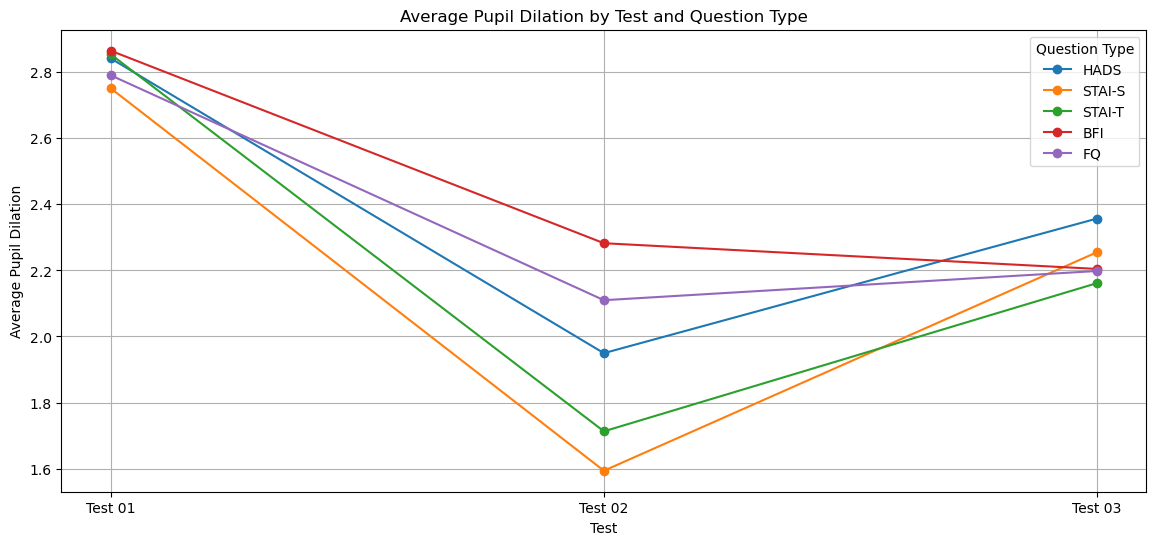

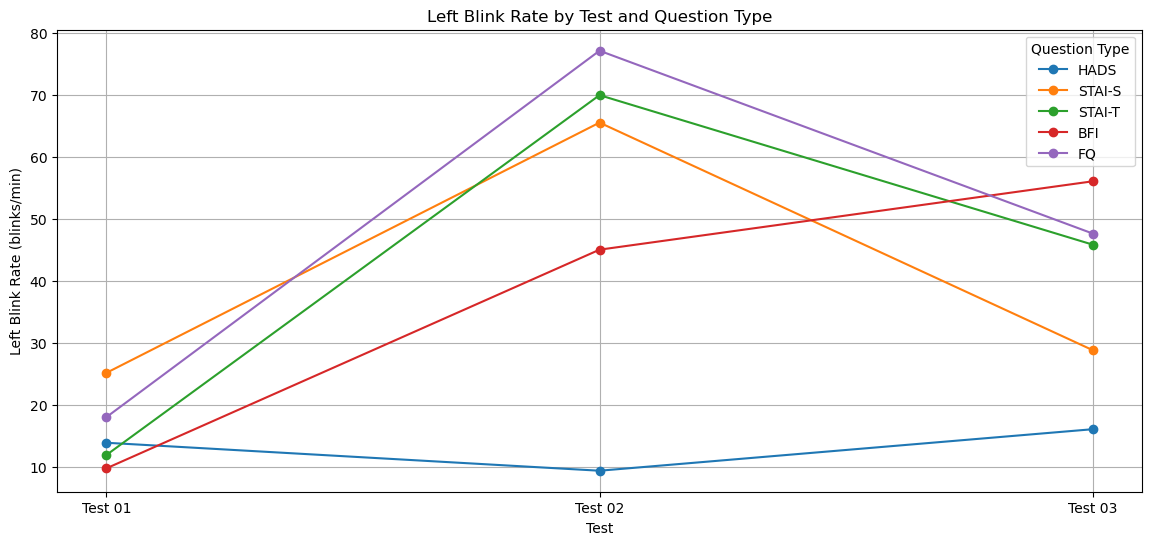

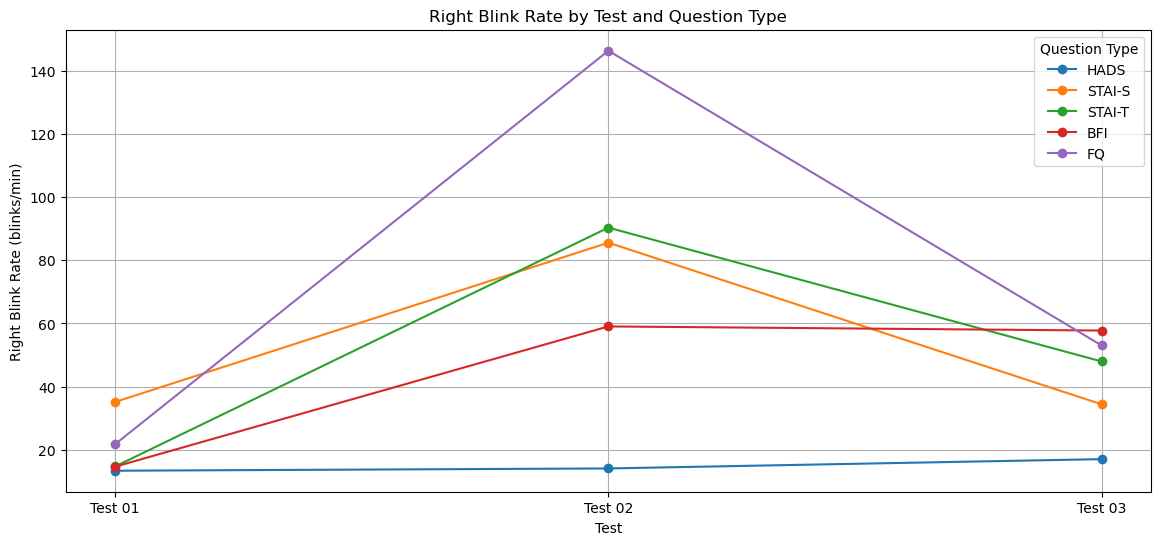

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
baseline_eye_tracking = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed.csv')
eye_tracking_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_01.csv')
eye_tracking_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_02.csv')
eye_tracking_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_03.csv')
psychometric_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_01.csv')
psychometric_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_02.csv')
psychometric_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_03.csv')

# Rename columns based on actual column names
columns_mapping = {
    'datetime': 'timestamp',
    'pupil': 'pupil_dilation',
    'leftEyeOpen': 'left_blink',
    'rightEyeOpen': 'right_blink'
}

baseline_eye_tracking.rename(columns=columns_mapping, inplace=True)
eye_tracking_01.rename(columns=columns_mapping, inplace=True)
eye_tracking_02.rename(columns=columns_mapping, inplace=True)
eye_tracking_03.rename(columns=columns_mapping, inplace=True)

# Function to clean eye-tracking data
def clean_eye_tracking_data(eye_tracking_data):
    eye_tracking_data['timestamp'] = pd.to_datetime(eye_tracking_data['timestamp'], errors='coerce').dt.tz_localize(None)
    eye_tracking_data = eye_tracking_data.dropna(subset=['timestamp'])
    return eye_tracking_data

# Clean the data
baseline_eye_tracking = clean_eye_tracking_data(baseline_eye_tracking)
eye_tracking_01 = clean_eye_tracking_data(eye_tracking_01)
eye_tracking_02 = clean_eye_tracking_data(eye_tracking_02)
eye_tracking_03 = clean_eye_tracking_data(eye_tracking_03)

# Clean and prepare the psychometric data
psychometric_01.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_02.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_03.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']

psychometric_01['Question Start Time'] = pd.to_datetime(psychometric_01['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Start Time'] = pd.to_datetime(psychometric_02['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Start Time'] = pd.to_datetime(psychometric_03['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_01['Question Answer Time'] = pd.to_datetime(psychometric_01['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Answer Time'] = pd.to_datetime(psychometric_02['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Answer Time'] = pd.to_datetime(psychometric_03['Question Answer Time'], errors='coerce').dt.tz_localize(None)

psychometric_01 = psychometric_01.dropna(subset=['Question Start Time'])
psychometric_02 = psychometric_02.dropna(subset=['Question Start Time'])
psychometric_03 = psychometric_03.dropna(subset=['Question Start Time'])

# Function to filter eye-tracking data based on question times
def filter_eye_tracking_data(eye_tracking_data, questions):
    start_time = questions['Question Start Time'].min()
    end_time = questions['Question Answer Time'].max()
    return eye_tracking_data[(eye_tracking_data['timestamp'] >= start_time) & (eye_tracking_data['timestamp'] <= end_time)]

# Function to calculate eye-tracking metrics
def calculate_eye_tracking_metrics(eye_tracking_data):
    average_pupil_dilation = eye_tracking_data['pupil_dilation'].mean()
    blink_detection_threshold = 1.0  # Threshold value to detect closed eyes
    left_blink_count = ((eye_tracking_data['left_blink'] > blink_detection_threshold) & 
                        (eye_tracking_data['left_blink'].shift(-1) <= blink_detection_threshold)).sum()
    right_blink_count = ((eye_tracking_data['right_blink'] > blink_detection_threshold) & 
                         (eye_tracking_data['right_blink'].shift(-1) <= blink_detection_threshold)).sum()
    total_duration_minutes = (eye_tracking_data['timestamp'].max() - eye_tracking_data['timestamp'].min()).total_seconds() / 60
    left_blink_rate = left_blink_count / total_duration_minutes
    right_blink_rate = right_blink_count / total_duration_minutes
    return average_pupil_dilation, left_blink_rate, right_blink_rate

# Function to detect significant increases compared to baseline
def detect_significant_increase(test_metrics, baseline_metrics):
    pupil_dilation_increase = test_metrics[0] > baseline_metrics[0]
    left_blink_rate_increase = test_metrics[1] > baseline_metrics[1]
    right_blink_rate_increase = test_metrics[2] > baseline_metrics[2]
    return pupil_dilation_increase, left_blink_rate_increase, right_blink_rate_increase

# Calculate baseline metrics
baseline_metrics = calculate_eye_tracking_metrics(baseline_eye_tracking)

# Process data for each psychometric test
results = []

question_types = ['HADS', 'STAI-S', 'STAI-T', 'BFI', 'FQ']
psychometric_data = {
    'HADS': [psychometric_01[psychometric_01['Type'] == 'HADS'], psychometric_02[psychometric_02['Type'] == 'HADS'], psychometric_03[psychometric_03['Type'] == 'HADS']],
    'STAI-S': [psychometric_01[psychometric_01['Type'] == 'STAI-S'], psychometric_02[psychometric_02['Type'] == 'STAI-S'], psychometric_03[psychometric_03['Type'] == 'STAI-S']],
    'STAI-T': [psychometric_01[psychometric_01['Type'] == 'STAI-T'], psychometric_02[psychometric_02['Type'] == 'STAI-T'], psychometric_03[psychometric_03['Type'] == 'STAI-T']],
    'BFI': [psychometric_01[psychometric_01['Type'] == 'BFI'], psychometric_02[psychometric_02['Type'] == 'BFI'], psychometric_03[psychometric_03['Type'] == 'BFI']],
    'FQ': [psychometric_01[psychometric_01['Type'] == 'FQ'], psychometric_02[psychometric_02['Type'] == 'FQ'], psychometric_03[psychometric_03['Type'] == 'FQ']]
}

for question_type in question_types:
    questions_01, questions_02, questions_03 = psychometric_data[question_type]

    eye_tracking_hads_01 = filter_eye_tracking_data(eye_tracking_01, questions_01)
    eye_tracking_hads_02 = filter_eye_tracking_data(eye_tracking_02, questions_02)
    eye_tracking_hads_03 = filter_eye_tracking_data(eye_tracking_03, questions_03)

    metrics_01 = calculate_eye_tracking_metrics(eye_tracking_hads_01)
    metrics_02 = calculate_eye_tracking_metrics(eye_tracking_hads_02)
    metrics_03 = calculate_eye_tracking_metrics(eye_tracking_hads_03)

    significant_increase_01 = detect_significant_increase(metrics_01, baseline_metrics)
    significant_increase_02 = detect_significant_increase(metrics_02, baseline_metrics)
    significant_increase_03 = detect_significant_increase(metrics_03, baseline_metrics)

    results.append({'Test': 'Test 01', 'Type': question_type, 'Start Time': questions_01['Question Start Time'].min().strftime('%H:%M:%S'), 'End Time': questions_01['Question Answer Time'].max().strftime('%H:%M:%S'),
                    'Average Pupil Dilation': metrics_01[0], 'Left Blink Rate': metrics_01[1], 'Right Blink Rate': metrics_01[2],
                    'Significant Increase (Pupil Dilation)': significant_increase_01[0], 'Significant Increase (Left Blink Rate)': significant_increase_01[1],
                    'Significant Increase (Right Blink Rate)': significant_increase_01[2]})

    results.append({'Test': 'Test 02', 'Type': question_type, 'Start Time': questions_02['Question Start Time'].min().strftime('%H:%M:%S'), 'End Time': questions_02['Question Answer Time'].max().strftime('%H:%M:%S'),
                    'Average Pupil Dilation': metrics_02[0], 'Left Blink Rate': metrics_02[1], 'Right Blink Rate': metrics_02[2],
                    'Significant Increase (Pupil Dilation)': significant_increase_02[0], 'Significant Increase (Left Blink Rate)': significant_increase_02[1],
                    'Significant Increase (Right Blink Rate)': significant_increase_02[2]})

    results.append({'Test': 'Test 03', 'Type': question_type, 'Start Time': questions_03['Question Start Time'].min().strftime('%H:%M:%S'), 'End Time': questions_03['Question Answer Time'].max().strftime('%H:%M:%S'),
                    'Average Pupil Dilation': metrics_03[0], 'Left Blink Rate': metrics_03[1], 'Right Blink Rate': metrics_03[2],
                    'Significant Increase (Pupil Dilation)': significant_increase_03[0], 'Significant Increase (Left Blink Rate)': significant_increase_03[1],
                    'Significant Increase (Right Blink Rate)': significant_increase_03[2]})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Plot the average pupil dilation for each test and question type
plt.figure(figsize=(14, 6))
for question_type in question_types:
    subset = results_df[results_df['Type'] == question_type]
    plt.plot(subset['Test'], subset['Average Pupil Dilation'], marker='o', label=question_type)

plt.title('Average Pupil Dilation by Test and Question Type')
plt.xlabel('Test')
plt.ylabel('Average Pupil Dilation')
plt.legend(title='Question Type')
plt.grid(True)
plt.show()

# Plot the left blink rate for each test and question type
plt.figure(figsize=(14, 6))
for question_type in question_types:
    subset = results_df[results_df['Type'] == question_type]
    plt.plot(subset['Test'], subset['Left Blink Rate'], marker='o', label=question_type)

plt.title('Left Blink Rate by Test and Question Type')
plt.xlabel('Test')
plt.ylabel('Left Blink Rate (blinks/min)')
plt.legend(title='Question Type')
plt.grid(True)
plt.show()

# Plot the right blink rate for each test and question type
plt.figure(figsize=(14, 6))
for question_type in question_types:
    subset = results_df[results_df['Type'] == question_type]
    plt.plot(subset['Test'], subset['Right Blink Rate'], marker='o', label=question_type)

plt.title('Right Blink Rate by Test and Question Type')
plt.xlabel('Test')
plt.ylabel('Right Blink Rate (blinks/min)')
plt.legend(title='Question Type')
plt.grid(True)
plt.show()

In [31]:
import pandas as pd

# Load the data
baseline_eye_tracking = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed.csv')
eye_tracking_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_01.csv')
eye_tracking_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_02.csv')
eye_tracking_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_03.csv')
psychometric_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_01.csv')
psychometric_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_02.csv')
psychometric_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_03.csv')

# Rename columns based on actual column names
columns_mapping = {
    'datetime': 'timestamp',
    'pupil': 'pupil_dilation',
    'leftEyeOpen': 'left_blink',
    'rightEyeOpen': 'right_blink'
}

baseline_eye_tracking.rename(columns=columns_mapping, inplace=True)
eye_tracking_01.rename(columns=columns_mapping, inplace=True)
eye_tracking_02.rename(columns=columns_mapping, inplace=True)
eye_tracking_03.rename(columns=columns_mapping, inplace=True)

# Function to clean eye-tracking data
def clean_eye_tracking_data(eye_tracking_data):
    eye_tracking_data['timestamp'] = pd.to_datetime(eye_tracking_data['timestamp'], errors='coerce').dt.tz_localize(None)
    eye_tracking_data = eye_tracking_data.dropna(subset=['timestamp'])
    return eye_tracking_data

# Clean the data
baseline_eye_tracking = clean_eye_tracking_data(baseline_eye_tracking)
eye_tracking_01 = clean_eye_tracking_data(eye_tracking_01)
eye_tracking_02 = clean_eye_tracking_data(eye_tracking_02)
eye_tracking_03 = clean_eye_tracking_data(eye_tracking_03)

# Clean and prepare the psychometric data
psychometric_01.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_02.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_03.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']

psychometric_01['Question Start Time'] = pd.to_datetime(psychometric_01['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Start Time'] = pd.to_datetime(psychometric_02['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Start Time'] = pd.to_datetime(psychometric_03['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_01['Question Answer Time'] = pd.to_datetime(psychometric_01['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Answer Time'] = pd.to_datetime(psychometric_02['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Answer Time'] = pd.to_datetime(psychometric_03['Question Answer Time'], errors='coerce').dt.tz_localize(None)

psychometric_01 = psychometric_01.dropna(subset=['Question Start Time'])
psychometric_02 = psychometric_02.dropna(subset=['Question Start Time'])
psychometric_03 = psychometric_03.dropna(subset=['Question Start Time'])

# Function to filter eye-tracking data based on question times
def filter_eye_tracking_data(eye_tracking_data, questions):
    start_time = questions['Question Start Time'].min()
    end_time = questions['Question Answer Time'].max()
    return eye_tracking_data[(eye_tracking_data['timestamp'] >= start_time) & (eye_tracking_data['timestamp'] <= end_time)]

# Function to calculate eye-tracking metrics
def calculate_eye_tracking_metrics(eye_tracking_data):
    average_pupil_dilation = eye_tracking_data['pupil_dilation'].mean()
    blink_detection_threshold = 1.0  # Threshold value to detect closed eyes
    left_blink_count = ((eye_tracking_data['left_blink'] > blink_detection_threshold) & 
                        (eye_tracking_data['left_blink'].shift(-1) <= blink_detection_threshold)).sum()
    right_blink_count = ((eye_tracking_data['right_blink'] > blink_detection_threshold) & 
                         (eye_tracking_data['right_blink'].shift(-1) <= blink_detection_threshold)).sum()
    total_duration_minutes = (eye_tracking_data['timestamp'].max() - eye_tracking_data['timestamp'].min()).total_seconds() / 60
    left_blink_rate = left_blink_count / total_duration_minutes
    right_blink_rate = right_blink_count / total_duration_minutes
    return average_pupil_dilation, left_blink_rate, right_blink_rate

# Function to detect significant increases compared to baseline
def detect_significant_increase(test_metrics, baseline_metrics):
    pupil_dilation_increase = test_metrics[0] > baseline_metrics[0]
    left_blink_rate_increase = test_metrics[1] > baseline_metrics[1]
    right_blink_rate_increase = test_metrics[2] > baseline_metrics[2]
    return pupil_dilation_increase, left_blink_rate_increase, right_blink_rate_increase

# Calculate baseline metrics
baseline_metrics = calculate_eye_tracking_metrics(baseline_eye_tracking)

# Process data for each psychometric test
results = []

question_types = ['HADS', 'STAI-S', 'STAI-T', 'BFI', 'FQ']
psychometric_data = {
    'HADS': [psychometric_01[psychometric_01['Type'] == 'HADS'], psychometric_02[psychometric_02['Type'] == 'HADS'], psychometric_03[psychometric_03['Type'] == 'HADS']],
    'STAI-S': [psychometric_01[psychometric_01['Type'] == 'STAI-S'], psychometric_02[psychometric_02['Type'] == 'STAI-S'], psychometric_03[psychometric_03['Type'] == 'STAI-S']],
    'STAI-T': [psychometric_01[psychometric_01['Type'] == 'STAI-T'], psychometric_02[psychometric_02['Type'] == 'STAI-T'], psychometric_03[psychometric_03['Type'] == 'STAI-T']],
    'BFI': [psychometric_01[psychometric_01['Type'] == 'BFI'], psychometric_02[psychometric_02['Type'] == 'BFI'], psychometric_03[psychometric_03['Type'] == 'BFI']],
    'FQ': [psychometric_01[psychometric_01['Type'] == 'FQ'], psychometric_02[psychometric_02['Type'] == 'FQ'], psychometric_03[psychometric_03['Type'] == 'FQ']]
}

for question_type in question_types:
    questions_01, questions_02, questions_03 = psychometric_data[question_type]

    eye_tracking_hads_01 = filter_eye_tracking_data(eye_tracking_01, questions_01)
    eye_tracking_hads_02 = filter_eye_tracking_data(eye_tracking_02, questions_02)
    eye_tracking_hads_03 = filter_eye_tracking_data(eye_tracking_03, questions_03)

    metrics_01 = calculate_eye_tracking_metrics(eye_tracking_hads_01)
    metrics_02 = calculate_eye_tracking_metrics(eye_tracking_hads_02)
    metrics_03 = calculate_eye_tracking_metrics(eye_tracking_hads_03)

    significant_increase_01 = detect_significant_increase(metrics_01, baseline_metrics)
    significant_increase_02 = detect_significant_increase(metrics_02, baseline_metrics)
    significant_increase_03 = detect_significant_increase(metrics_03, baseline_metrics)

    results.append({'Test': 'Test 01', 'Type': question_type, 'Start Time': questions_01['Question Start Time'].min().strftime('%H:%M:%S'), 'End Time': questions_01['Question Answer Time'].max().strftime('%H:%M:%S'),
                    'Average Pupil Dilation': metrics_01[0], 'Left Blink Rate': metrics_01[1], 'Right Blink Rate': metrics_01[2],
                    'Significant Increase (Pupil Dilation)': significant_increase_01[0], 'Significant Increase (Left Blink Rate)': significant_increase_01[1],
                    'Significant Increase (Right Blink Rate)': significant_increase_01[2]})

    results.append({'Test': 'Test 02', 'Type': question_type, 'Start Time': questions_02['Question Start Time'].min().strftime('%H:%M:%S'), 'End Time': questions_02['Question Answer Time'].max().strftime('%H:%M:%S'),
                    'Average Pupil Dilation': metrics_02[0], 'Left Blink Rate': metrics_02[1], 'Right Blink Rate': metrics_02[2],
                    'Significant Increase (Pupil Dilation)': significant_increase_02[0], 'Significant Increase (Left Blink Rate)': significant_increase_02[1],
                                        'Significant Increase (Right Blink Rate)': significant_increase_02[2]})

    results.append({'Test': 'Test 03', 'Type': question_type, 'Start Time': questions_03['Question Start Time'].min().strftime('%H:%M:%S'), 'End Time': questions_03['Question Answer Time'].max().strftime('%H:%M:%S'),
                    'Average Pupil Dilation': metrics_03[0], 'Left Blink Rate': metrics_03[1], 'Right Blink Rate': metrics_03[2],
                    'Significant Increase (Pupil Dilation)': significant_increase_03[0], 'Significant Increase (Left Blink Rate)': significant_increase_03[1],
                    'Significant Increase (Right Blink Rate)': significant_increase_03[2]})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Display the results for each question type
for question_type in question_types:
    print(f"\nResults for {question_type}:\n")
    subset = results_df[results_df['Type'] == question_type]
    for index, row in subset.iterrows():
        print(f"Test {row['Test']}:")
        print(f"  Start Time: {row['Start Time']}")
        print(f"  End Time: {row['End Time']}")
        print(f"  Average Pupil Dilation: {row['Average Pupil Dilation']:.2f}")
        print(f"  Left Blink Rate: {row['Left Blink Rate']:.2f} blinks/min")
        print(f"  Right Blink Rate: {row['Right Blink Rate']:.2f} blinks/min")
        print(f"  Significant Increase (Pupil Dilation): {'Yes' if row['Significant Increase (Pupil Dilation)'] else 'No'}")
        print(f"  Significant Increase (Left Blink Rate): {'Yes' if row['Significant Increase (Left Blink Rate)'] else 'No'}")
        print(f"  Significant Increase (Right Blink Rate): {'Yes' if row['Significant Increase (Right Blink Rate)'] else 'No'}\n")


Results for HADS:

Test Test 01:
  Start Time: 11:30:18
  End Time: 11:32:10
  Average Pupil Dilation: 2.84
  Left Blink Rate: 13.91 blinks/min
  Right Blink Rate: 13.38 blinks/min
  Significant Increase (Pupil Dilation): Yes
  Significant Increase (Left Blink Rate): No
  Significant Increase (Right Blink Rate): No

Test Test 02:
  Start Time: 09:41:08
  End Time: 09:42:25
  Average Pupil Dilation: 1.95
  Left Blink Rate: 9.40 blinks/min
  Right Blink Rate: 14.10 blinks/min
  Significant Increase (Pupil Dilation): No
  Significant Increase (Left Blink Rate): No
  Significant Increase (Right Blink Rate): No

Test Test 03:
  Start Time: 12:48:35
  End Time: 12:49:38
  Average Pupil Dilation: 2.36
  Left Blink Rate: 16.10 blinks/min
  Right Blink Rate: 17.04 blinks/min
  Significant Increase (Pupil Dilation): No
  Significant Increase (Left Blink Rate): Yes
  Significant Increase (Right Blink Rate): Yes


Results for STAI-S:

Test Test 01:
  Start Time: 11:32:10
  End Time: 11:34:04
  Av

In [35]:
import pandas as pd

# Load the data
baseline_eye_tracking = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed.csv')
eye_tracking_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_01.csv')
eye_tracking_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_02.csv')
eye_tracking_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/sed_03.csv')
psychometric_01 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_01.csv')
psychometric_02 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_02.csv')
psychometric_03 = pd.read_csv('/Users/urmebose/Desktop/People/Nuro/Psychometric_Test_Results_03.csv')

# Rename columns based on actual column names
columns_mapping = {
    'datetime': 'timestamp',
    'pupil': 'pupil_dilation',
    'leftEyeOpen': 'left_blink',
    'rightEyeOpen': 'right_blink'
}

baseline_eye_tracking.rename(columns=columns_mapping, inplace=True)
eye_tracking_01.rename(columns=columns_mapping, inplace=True)
eye_tracking_02.rename(columns=columns_mapping, inplace=True)
eye_tracking_03.rename(columns=columns_mapping, inplace=True)

# Function to clean eye-tracking data
def clean_eye_tracking_data(eye_tracking_data):
    eye_tracking_data['timestamp'] = pd.to_datetime(eye_tracking_data['timestamp'], errors='coerce').dt.tz_localize(None)
    eye_tracking_data = eye_tracking_data.dropna(subset=['timestamp'])
    return eye_tracking_data

# Clean the data
baseline_eye_tracking = clean_eye_tracking_data(baseline_eye_tracking)
eye_tracking_01 = clean_eye_tracking_data(eye_tracking_01)
eye_tracking_02 = clean_eye_tracking_data(eye_tracking_02)
eye_tracking_03 = clean_eye_tracking_data(eye_tracking_03)

# Clean and prepare the psychometric data
psychometric_01.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_02.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']
psychometric_03.columns = ['Type', 'Test', 'Question', 'Answer', 'Time(s)', 'Question Start Time', 'Question Answer Time']

psychometric_01['Question Start Time'] = pd.to_datetime(psychometric_01['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Start Time'] = pd.to_datetime(psychometric_02['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Start Time'] = pd.to_datetime(psychometric_03['Question Start Time'], errors='coerce').dt.tz_localize(None)
psychometric_01['Question Answer Time'] = pd.to_datetime(psychometric_01['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_02['Question Answer Time'] = pd.to_datetime(psychometric_02['Question Answer Time'], errors='coerce').dt.tz_localize(None)
psychometric_03['Question Answer Time'] = pd.to_datetime(psychometric_03['Question Answer Time'], errors='coerce').dt.tz_localize(None)

psychometric_01 = psychometric_01.dropna(subset=['Question Start Time'])
psychometric_02 = psychometric_02.dropna(subset=['Question Start Time'])
psychometric_03 = psychometric_03.dropna(subset=['Question Start Time'])

# Function to filter eye-tracking data based on question times
def filter_eye_tracking_data(eye_tracking_data, questions):
    start_time = questions['Question Start Time'].min()
    end_time = questions['Question Answer Time'].max()
    return eye_tracking_data[(eye_tracking_data['timestamp'] >= start_time) & (eye_tracking_data['timestamp'] <= end_time)]

# Function to calculate eye-tracking metrics
def calculate_eye_tracking_metrics(eye_tracking_data):
    average_pupil_dilation = eye_tracking_data['pupil_dilation'].mean()
    blink_detection_threshold = 1.0  # Threshold value to detect closed eyes
    left_blink_count = ((eye_tracking_data['left_blink'] > blink_detection_threshold) & 
                        (eye_tracking_data['left_blink'].shift(-1) <= blink_detection_threshold)).sum()
    right_blink_count = ((eye_tracking_data['right_blink'] > blink_detection_threshold) & 
                         (eye_tracking_data['right_blink'].shift(-1) <= blink_detection_threshold)).sum()
    total_duration_minutes = (eye_tracking_data['timestamp'].max() - eye_tracking_data['timestamp'].min()).total_seconds() / 60
    left_blink_rate = left_blink_count / total_duration_minutes
    right_blink_rate = right_blink_count / total_duration_minutes
    return average_pupil_dilation, left_blink_rate, right_blink_rate

# Calculate baseline metrics
baseline_metrics = calculate_eye_tracking_metrics(baseline_eye_tracking)

# Process data for each psychometric test
results = []

question_types = ['HADS', 'STAI-S', 'STAI-T', 'BFI', 'FQ']
psychometric_data = {
    'HADS': [psychometric_01[psychometric_01['Type'] == 'HADS'], psychometric_02[psychometric_02['Type'] == 'HADS'], psychometric_03[psychometric_03['Type'] == 'HADS']],
    'STAI-S': [psychometric_01[psychometric_01['Type'] == 'STAI-S'], psychometric_02[psychometric_02['Type'] == 'STAI-S'], psychometric_03[psychometric_03['Type'] == 'STAI-S']],
    'STAI-T': [psychometric_01[psychometric_01['Type'] == 'STAI-T'], psychometric_02[psychometric_02['Type'] == 'STAI-T'], psychometric_03[psychometric_03['Type'] == 'STAI-T']],
    'BFI': [psychometric_01[psychometric_01['Type'] == 'BFI'], psychometric_02[psychometric_02['Type'] == 'BFI'], psychometric_03[psychometric_03['Type'] == 'BFI']],
    'FQ': [psychometric_01[psychometric_01['Type'] == 'FQ'], psychometric_02[psychometric_02['Type'] == 'FQ'], psychometric_03[psychometric_03['Type'] == 'FQ']]
}

for question_type in question_types:
    questions_01, questions_02, questions_03 = psychometric_data[question_type]

    eye_tracking_01_filtered = filter_eye_tracking_data(eye_tracking_01, questions_01)
    eye_tracking_02_filtered = filter_eye_tracking_data(eye_tracking_02, questions_02)
    eye_tracking_03_filtered = filter_eye_tracking_data(eye_tracking_03, questions_03)

    metrics_01 = calculate_eye_tracking_metrics(eye_tracking_01_filtered)
    metrics_02 = calculate_eye_tracking_metrics(eye_tracking_02_filtered)
    metrics_03 = calculate_eye_tracking_metrics(eye_tracking_03_filtered)

    results.append({'Test': 'Test 01', 'Type': question_type, 'Start Time': questions_01['Question Start Time'].min().strftime('%H:%M:%S'), 'End Time': questions_01['Question Answer Time'].max().strftime('%H:%M:%S'),
                    'Average Pupil Dilation': metrics_01[0], 'Left Blink Rate': metrics_01[1], 'Right Blink Rate': metrics_01[2]})

    results.append({'Test': 'Test 02', 'Type': question_type, 'Start Time': questions_02['Question Start Time'].min().strftime('%H:%M:%S'), 'End Time': questions_02['Question Answer Time'].max().strftime('%H:%M:%S'),
                    'Average Pupil Dilation': metrics_02[0], 'Left Blink Rate': metrics_02[1], 'Right Blink Rate': metrics_02[2]})

    results.append({'Test': 'Test 03', 'Type': question_type, 'Start Time': questions_03['Question Start Time'].min().strftime('%H:%M:%S'), 'End Time': questions_03['Question Answer Time'].max().strftime('%H:%M:%S'),
                    'Average Pupil Dilation': metrics_03[0], 'Left Blink Rate': metrics_03[1], 'Right Blink Rate': metrics_03[2]})

# Display the results in a table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

   Test   Type Start Time End Time  Average Pupil Dilation  Left Blink Rate  Right Blink Rate
Test 01   HADS   11:30:18 11:32:10                2.841711        13.913168         13.378046
Test 02   HADS   09:41:08 09:42:25                1.949553         9.399478         14.099217
Test 03   HADS   12:48:35 12:49:38                2.357059        16.096452         17.043303
Test 01 STAI-S   11:32:10 11:34:04                2.751345        25.183410         35.151844
Test 02 STAI-S   09:42:25 09:43:40                1.593644        65.565906         85.555511
Test 03 STAI-S   12:49:38 12:50:32                2.255183        28.851489         34.399852
Test 01 STAI-T   11:34:04 11:35:30                2.854124        11.928708         14.735463
Test 02 STAI-T   09:43:40 09:45:00                1.712913        69.996739         90.318372
Test 03 STAI-T   12:50:32 12:51:30                2.161578        45.875545         47.960797
Test 01    BFI   11:35:30 11:36:06                2.865006  